# Практическое задание №11 по теме "Модель Transformer-1".

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
path_to_file = "C:/Study/fra.txt"

In [3]:
def preprocess_sentence(w):
  w = w.lower().strip()
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)
  w = w.strip()
  w = '<start> ' + w + ' <end>'
  return w

In [4]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]
  return zip(*word_pairs)

In [5]:
en, fra = create_dataset(path_to_file, None)
print(en[-1])
print(fra[-1])

<start> it may be impossible to get a completely error free corpus due to the nature of this kind of collaborative effort . however , if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning , we might be able to minimize errors . <end>
<start> il est peut tre impossible d'obtenir un corpus compl tement d nu de fautes , tant donn e la nature de ce type d'entreprise collaborative . cependant , si nous encourageons les membres produire des phrases dans leurs propres langues plut t que d'exp rimenter dans les langues qu'ils apprennent , nous pourrions tre en mesure de r duire les erreurs . <end>


In [6]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor, lang_tokenizer

In [7]:
def load_dataset(path, num_examples=None):
  targ_lang, inp_lang = create_dataset(path, num_examples)
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [8]:
len(en), len(fra)

(217975, 217975)

In [9]:
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [10]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [11]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [12]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 19]), TensorShape([64, 12]))

In [13]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [14]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 19, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [15]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [16]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 19, 1)


In [17]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)

    return x, state, attention_weights

In [18]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 8865)


In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [20]:
checkpoint_dir = 'C:/Study/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=decoder)

In [21]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [22]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.8999
Epoch 1 Batch 100 Loss 2.3260
Epoch 1 Batch 200 Loss 2.1053
Epoch 1 Batch 300 Loss 1.8964
Epoch 1 Batch 400 Loss 1.7412
Epoch 1 Batch 500 Loss 1.6865
Epoch 1 Batch 600 Loss 1.6062
Epoch 1 Batch 700 Loss 1.4131
Epoch 1 Batch 800 Loss 1.3909
Epoch 1 Batch 900 Loss 1.3168
Epoch 1 Batch 1000 Loss 1.0875
Epoch 1 Batch 1100 Loss 1.2496
Epoch 1 Batch 1200 Loss 0.9713
Epoch 1 Loss 1.5889
Time taken for 1 epoch 1949.6328341960907 sec

Epoch 2 Batch 0 Loss 0.8865
Epoch 2 Batch 100 Loss 1.1181
Epoch 2 Batch 200 Loss 0.7811
Epoch 2 Batch 300 Loss 0.7821
Epoch 2 Batch 400 Loss 0.7979
Epoch 2 Batch 500 Loss 0.8576
Epoch 2 Batch 600 Loss 0.8238
Epoch 2 Batch 700 Loss 0.7861
Epoch 2 Batch 800 Loss 0.6234
Epoch 2 Batch 900 Loss 0.7292
Epoch 2 Batch 1000 Loss 0.6891
Epoch 2 Batch 1100 Loss 0.7471
Epoch 2 Batch 1200 Loss 0.6897
Epoch 2 Loss 0.7556
Time taken for 1 epoch 1965.7062690258026 sec

Epoch 3 Batch 0 Loss 0.5294
Epoch 3 Batch 100 Loss 0.5008
Epoch 3 Batch 200 Loss 0.3

In [23]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [24]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')
  fontdict = {'fontsize': 14}
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

In [25]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [26]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> je vois tous les gens du monde . <end>
Predicted translation: i see everyone . <end> 


C:\Users\rfk03\AppData\Local\Temp\ipykernel_7948\2445879938.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\rfk03\AppData\Local\Temp\ipykernel_7948\2445879938.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


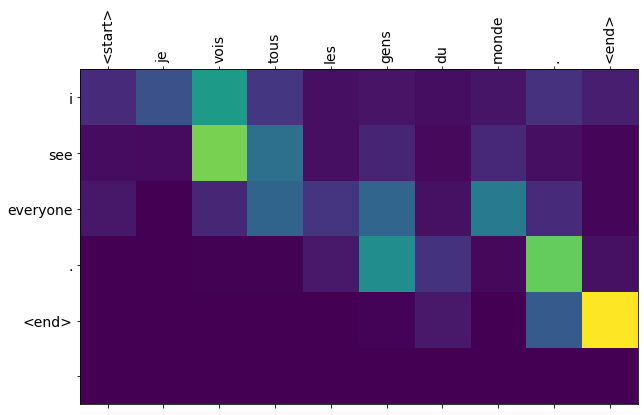

In [27]:
translate("Je vois tous les gens du monde.")

Input: <start> ils voulaient voyager . <end>
Predicted translation: they wanted to travel . <end> 


C:\Users\rfk03\AppData\Local\Temp\ipykernel_7948\2445879938.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\rfk03\AppData\Local\Temp\ipykernel_7948\2445879938.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


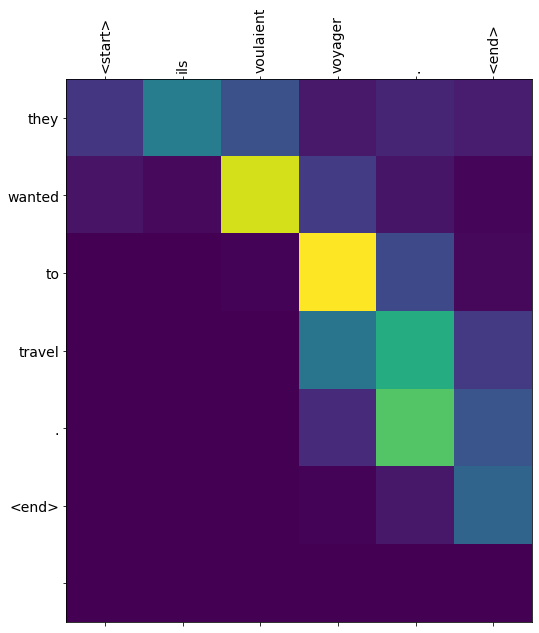

In [28]:
translate("Ils voulaient voyager.")

Input: <start> voler vers le ciel est notre espoir . <end>
Predicted translation: something's over the full support . <end> 


C:\Users\rfk03\AppData\Local\Temp\ipykernel_7948\2445879938.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\rfk03\AppData\Local\Temp\ipykernel_7948\2445879938.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


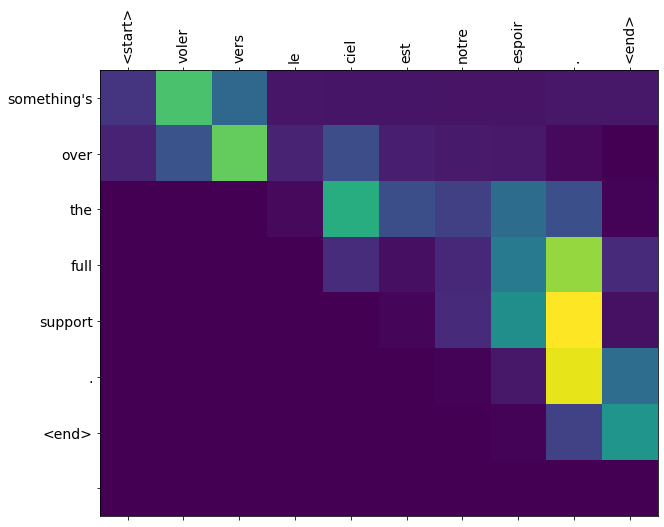

In [29]:
translate("Voler vers le ciel est notre espoir.")

---